In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import numpy as np
import scipy as sp
from funimag import superpixel_analysis as sup
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style("white")
%matplotlib inline
fish_path = os.path.abspath(os.path.join('..'))
if fish_path not in sys.path:
    sys.path.append(fish_path)
from utils.demix import recompute_nmf
import pickle

## 1. Load denoised data

In [2]:
dat_ = np.load('tmpData/Y_denoised_svd.npz')
Y_amp = dat_['Y_amp']
Y_ave = dat_['Y_ave']
Y_svd = dat_['Y_svd']
ave_trend = dat_['ave_trend']
mov = Y_svd * Y_amp

## 2. Demixing pipeline on raw data

In [3]:
# mov_ = mov + np.random.normal(size=Y_svd.shape)*0.7
# pass_num = 3
# rlt_= sup.demix_whole_data(-mov_, cut_off_point=[0.6,0.6,0.5,0.4], length_cut=[25,25,25,25], th=[2,1,1,1], 
#                            pass_num=pass_num, residual_cut = [0.6,0.6,0.6, 0.6], corr_th_fix=0.3, 
#                            max_allow_neuron_size=0.2, merge_corr_thr=0.5, merge_overlap_thr=0.8, 
#                            num_plane=1, patch_size=[50, 50], plot_en=False, TF=False, fudge_factor=1, 
#                            text=False, bg=False, max_iter=60, max_iter_fin=100, update_after=4)
# # with open('tmpData/Y_demix_rlt.pkl', 'wb') as file_:
# #     pickle.dump(rlt_, file_)

In [4]:
with open('tmpData/Y_demix_rlt.pkl', 'rb') as f:
    rlt_ = pickle.load(f)

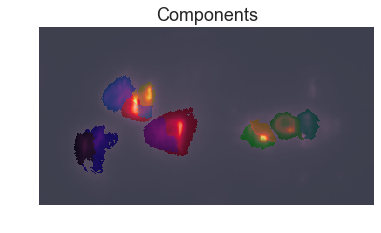

In [5]:
# pass_num = 3
# for n_pass in range(pass_num):
#     sup.pure_superpixel_single_plot(rlt_["superpixel_rlt"][n_pass]["connect_mat_1"],
#                                     rlt_["superpixel_rlt"][n_pass]["unique_pix"],
#                                     rlt_["superpixel_rlt"][n_pass]["brightness_rank_sup"],
#                                     text=True,
#                                     pure=False);
#     plt.show()
A = rlt_['fin_rlt']['a']
A_ = A[:, (A>0).sum(axis=0)>0] # min pixel = 40
A_comp = np.zeros(A_.shape[0])
A_comp[A_.sum(axis=-1)>0] = np.argmax(A_[A_.sum(axis=-1)>0, :], axis=-1) + 1
d1, d2, _ = mov.shape
# plt.figure(figsize=(15,5))
plt.imshow(ave_trend[:, :, 0])
plt.imshow(A_comp.reshape(d2, d1).T, cmap=plt.cm.nipy_spectral_r, alpha=0.3)
plt.title('Components')
plt.axis('off')
plt.show()

In [6]:
C_, b_, res_ = recompute_nmf(rlt_=rlt_, mov=-mov)

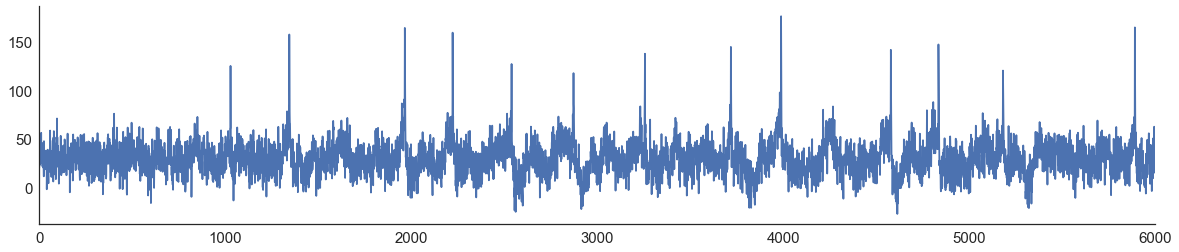

In [7]:
plt.figure(figsize=(20, 4))
nNeuron = 3
# C_trace = C_[nNeuron,:] - C_[nNeuron,:].min()
plt.plot(C_[nNeuron,:])
plt.xlim([0, 6000])
sns.despine()
plt.show()

### 2.1 Generate movie

In [8]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import animation

mov_detrend = -np.load('tmpData/Y_detr.npy')
mov_denoise = -(Y_svd * Y_amp + Y_ave)
mov_noise = mov_detrend - mov_denoise

A_ = rlt_['fin_rlt']['a']
mov_signal = np.matmul(A_, C_).reshape(mov.shape, order='F')
mov_background = b_
mov_res = res_

In [9]:
movs = [mov_detrend, mov_denoise, mov_signal, mov_background, mov_res, mov_noise]
titles = ['Detrend', 'Denoised', 'Signal', 'Background', 'Residual', 'Noise']

In [10]:
max_ = [_.max() for _ in movs]
min_ = [_.min() for _ in movs]

In [47]:
max_[1] = 1*3
min_[1] = -1
max_[4] = 0.6*3
min_[4] = -0.6

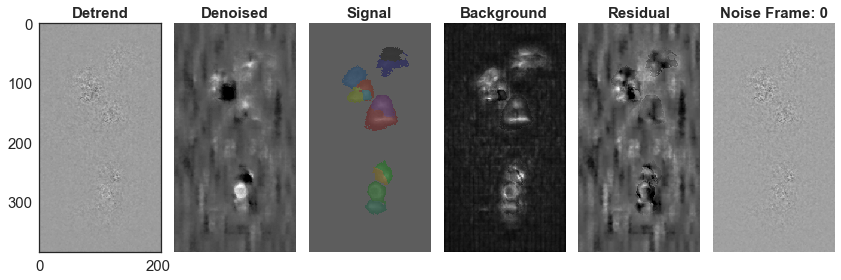

In [54]:
fig, axs = plt.subplots(1,6, figsize=(12, 4))
# for n_, nax in enumerate(ax):
#     nax.imshow(movs[n_][:, :, 0].T, vmax = max_, vmin = min_, cmap=plt.cm.gray)
#     nax.set_axis_off()
#     nax.set_title(titles[n_])
# plt.show()

for mdx in range(6):
    axs[mdx].set(title=titles[mdx])
    axs[mdx].title.set_fontsize(15)
    axs[mdx].title.set_fontweight("bold")
    if mdx>0:
        axs[mdx].set_axis_off()
        axs[mdx].set_xticklabels([])
        axs[mdx].set_yticklabels([])
axs[5].set(title=titles[5] + " Frame: {}".format(0))
axs[5].title.set_fontsize(15)
axs[5].title.set_fontweight("bold")
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

axs[2].imshow(A_comp.reshape(d2, d1), cmap=plt.cm.nipy_spectral_r)
imgs = [ax.imshow(movs[mdx][:,:, 0].T, vmin=min_[mdx], vmax=max_[mdx], cmap="Greys_r") for mdx, ax in enumerate(axs)]
imgs[2].set_alpha(0.8)

In [55]:
from matplotlib.animation import FFMpegFileWriter
def update(i):
    for mdx in [0, 1, 2, 4, 5]:
        imgs[mdx].set_data(movs[mdx][:,:,i].T);
    axs[5].set(title=titles[5] + " Frame: {}".format(i))
    axs[5].title.set_fontsize(15)
    axs[5].title.set_fontweight("bold")
    return imgs

num_frames = mov.shape[-1]
fps = 30
filename = 'tmpMovie/02212018Fish2-1.mp4'
ani = animation.FuncAnimation(fig, update, frames=num_frames, blit=True);
mywriter = FFMpegFileWriter(fps=25,codec="h264")
ani.save(filename, writer=mywriter)

## 3. Trend filtering

### 3.0 L1TF without removing spikes

In [ ]:
from trefide.temporal import TrendFilter
voltr_ = 1-C_[18,:]/C_[18,:].mean()

In [ ]:
filters = TrendFilter(len(voltr_))
denoised_voltr = filters.denoise(voltr_)

In [ ]:
plt.figure(figsize=(20, 4))
plt.plot(voltr_)
plt.plot(denoised_voltr)
plt.xlim([0, 6000])
sns.despine()
plt.show()

### 3.1 Spike detection

In [ ]:
from keras.models import load_model
from spikeDetectionNN.spikeDetector import prepare_sequences
from spikeDetectionNN.utils import detected_peak_spikes, plot_spks

In [ ]:
from glob import glob

In [ ]:
window_length = 40
trained_model = sorted(glob('tmpData/partly_trained_spikeDetector_20*.h5'))[-1]
m = load_model(trained_model)
spk = np.zeros(voltr_.shape)
x_, contain_outliers_ = prepare_sequences(voltr_, spk, window_length)

In [ ]:
spk_ = detected_peak_spikes(m, x_, voltr_, thres=0.6, devoltr_ = denoised_voltr, 
                            peakThres=.9, peak_minDist=10, smallPeakThres = 40)

In [ ]:
plt.figure(figsize=(20, 3))
plot_spks(plt, spk_, voltr_.max(), label='Detected spike time')
plt.plot(voltr_,'-k')
plt.xlabel('Frame')
plt.xlim([0, 6000])
# plt.legend(loc='upper center', bbox_to_anchor=(1.1, 1))
sns.despine()
plt.show()

### 3.2 L1TF

In [ ]:
tspk = np.where(spk_>0)[0]
tspk_win = tspk[:, None] + np.arange(-3, 3)[None, :]
tspk_win = tspk_win.reshape(-1)
nospike = np.zeros(spk_.shape)
nospike[tspk_win] = 1
tspk_ = np.where(nospike==0)[0]
int_voltr_ = voltr_.copy()
int_voltr_[tspk_win] = np.interp(tspk_win, tspk_, voltr_[tspk_])

In [ ]:
plt.figure(figsize=(20, 3))
plt.plot(voltr_)
plt.plot(int_voltr_)
plt.xlim([0, 1000])
plt.show()

In [ ]:
denoised_voltr_ = filters.denoise(int_voltr_)

In [ ]:
plt.figure(figsize=(20, 3))
plt.plot(denoised_voltr)
plt.plot(denoised_voltr_)
plt.xlim([0, 1000])
plt.show()

In [ ]:
plt.figure(figsize=(20, 3))
plt.plot(voltr_)
plt.plot(denoised_voltr_)
plt.xlim([0, 1000])
plt.show()